In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline

from simcodes.fitters import ExtendedLS
from gatspy.periodic import LombScargleMultiband
from KuiperMetric import KuiperVS

In [3]:
# Grab the current baseline file. Should have been downloaded with rubin_sim. 
# Can grab lots of different sims from: http://astro-lsst-01.astro.washington.edu:8081/
baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
conn = maf.db.OpsimDatabase(baseline_file)
outDir = 'temp'
resultsDb = maf.db.ResultsDb(outDir=outDir)

In [4]:
# Same for rolling cadence
rollDbFile = '/mnt/Data/Work/Sources/rubin_sim_data/experiments/rolling_all_sky_ns2_rw0.9_v2.0_10yrs.db'
rollName = os.path.split(rollDbFile)[-1].replace('.db', '')
rollDb = maf.db.OpsimDatabase(rollDbFile)
resultsDbRoll = maf.db.ResultsDb(outDir=outDir)
print(rollName)

rolling_all_sky_ns2_rw0.9_v2.0_10yrs


In [5]:
# Set range of periods for which we're gonna build the maps
perStep=100
numPoints=200
totalObsLength=365*5
#periods=np.round(np.linspace(perStep, numPoints*perStep,numPoints,dtype='float'),3)
periods=np.random.rand(numPoints)*totalObsLength
periods=periods.round(2)
periods.sort()

bundleList=[]
bundleListRoll=[]
ra = [0.]
dec = [-20]


for p in periods:
    metric = KuiperVS(period=p)
    sql = ''
    slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
    bundleList.append(maf.MetricBundle(metric, slicer, sql, runName='KuiperVSTest_'+str(p)))
    bundleListRoll.append(maf.MetricBundle(metric, slicer, sql, runName='RollKuiperVSTest_'+str(p)))

In [ ]:
bd = maf.metricBundles.makeBundlesDictFromList(bundleList)
bg = maf.metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database observations with no constraint for columns ['fieldDec', 'observationStartMJD', 'rotSkyPos', 'fieldRA'].
Found 2086980 visits
Running:  ['KuiperVSTest_10_8_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_16_97_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_17_05_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_42_3_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_43_23_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_58_05_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_62_11_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_63_53_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_67_48_KuiperVS_observationStartMJD_USER']
Completed metric genera

Completed metric generation.
Running:  ['KuiperVSTest_683_09_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_683_78_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_688_25_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_695_19_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_698_61_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_721_34_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_722_76_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_742_88_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_756_15_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_770_41_KuiperVS_observationStartMJD_USER']
Completed metric generation.
R

Completed metric generation.
Running:  ['KuiperVSTest_1520_84_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1526_67_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1542_25_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1545_37_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1573_08_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1576_41_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1578_9_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1582_46_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1592_91_KuiperVS_observationStartMJD_USER']
Completed metric generation.
Running:  ['KuiperVSTest_1595_62_KuiperVS_observationStartMJD_USER']
Completed metric gene

In [ ]:
bdRoll = maf.metricBundles.makeBundlesDictFromList(bundleListRoll)
bgRoll = maf.metricBundles.MetricBundleGroup(bdRoll, rollDb, outDir=outDir, resultsDb=resultsDbRoll)
bgRoll.runAll()

In [ ]:
getResultDict=lambda bList:{float(p.runName.split('_')[1]):p.metricValues.data[0] for p in bList}
periods=getResultDict(bundleList)
periodsRoll=getResultDict(bundleListRoll)

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(15,3))
ax.scatter(periods.keys(),periods.values(),s=2)
ax.scatter(periodsRoll.keys(),periodsRoll.values(),marker='s',s=2)

In [ ]:
metricPass = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth'])
bundleListPass=[]
bundleListPassRoll=[]

bundleListPass.append(maf.MetricBundle(metricPass, slicer, sql, runName='PassForAPoint'))
bdPass = maf.metricBundles.makeBundlesDictFromList(bundleListPass)
bgPass = maf.metricBundles.MetricBundleGroup(bdPass, conn, 
                                                outDir=outDir, resultsDb=resultsDb)
bgPass.runAll()

bundleListPassRoll.append(maf.MetricBundle(metricPass, slicer, sql, runName='PassForAPointRoll'))
bdPassRoll = maf.metricBundles.makeBundlesDictFromList(bundleListPassRoll)
bgPassRoll = maf.metricBundles.MetricBundleGroup(bdPassRoll, rollDb, 
                                                outDir=outDir, resultsDb=resultsDb)
bgPassRoll.runAll()

In [ ]:
def phasedCadence(period:float,dataSlice,mjdCol:str='observationStartMJD'):
    """
    Returns phase values for the timestamps of observatons
    """
    return (dataSlice[mjdCol]%float(period)/float(period))

/tmp/ipykernel_24993/272782600.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


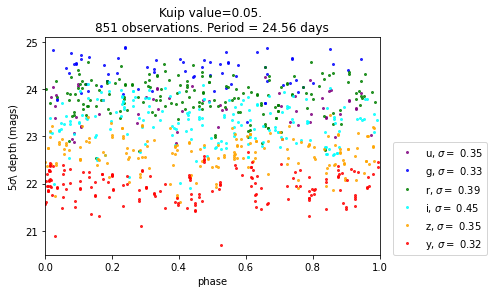

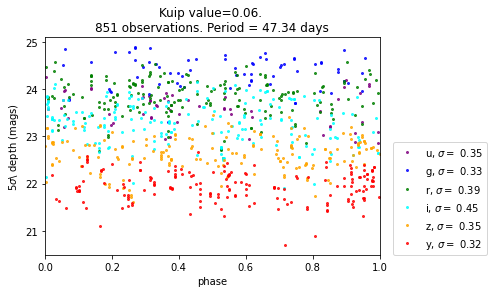

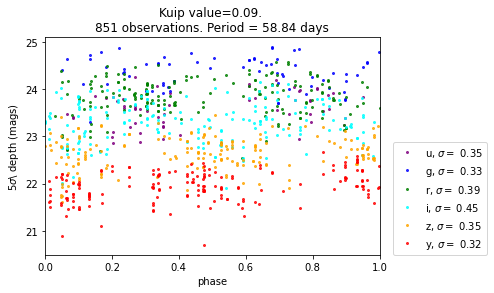

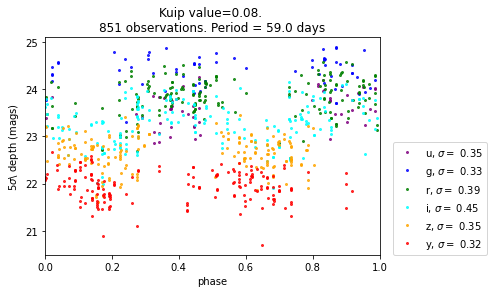

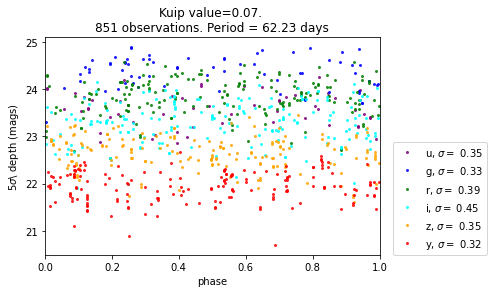

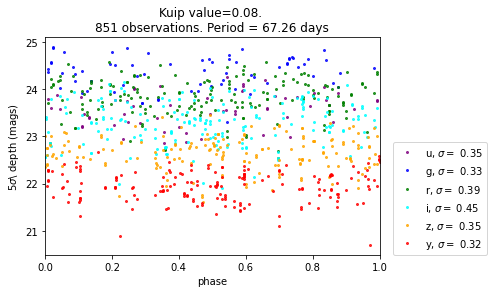

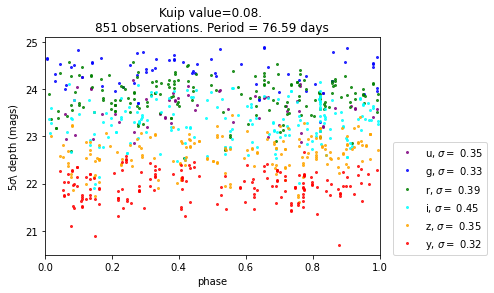

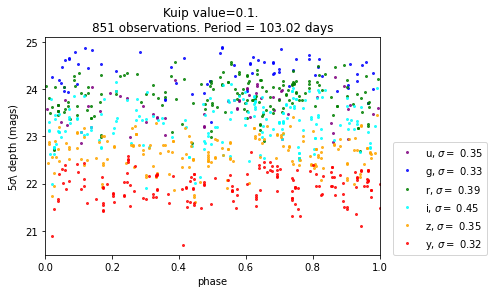

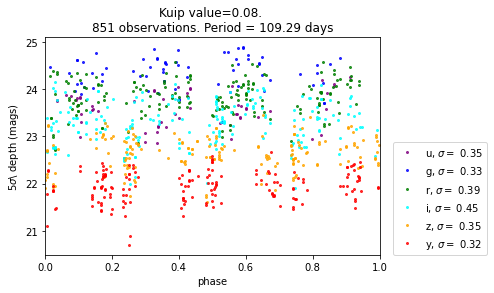

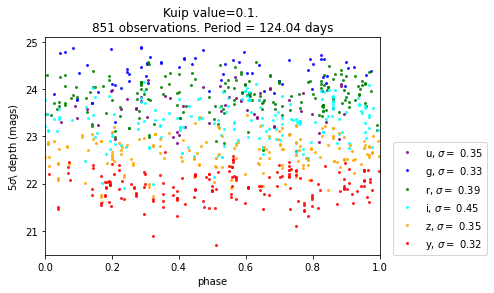

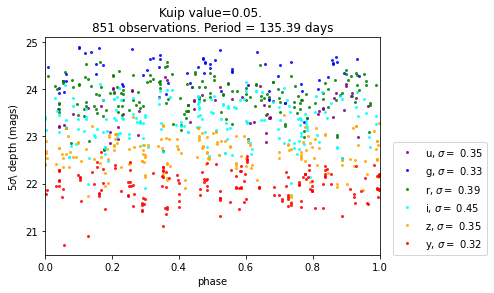

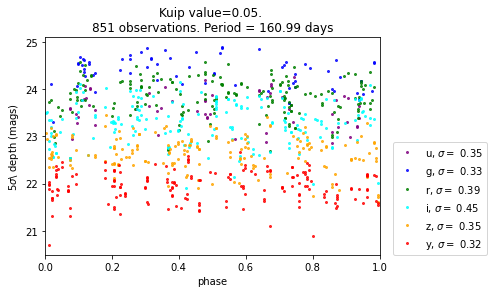

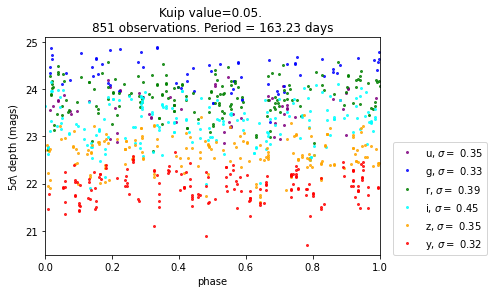

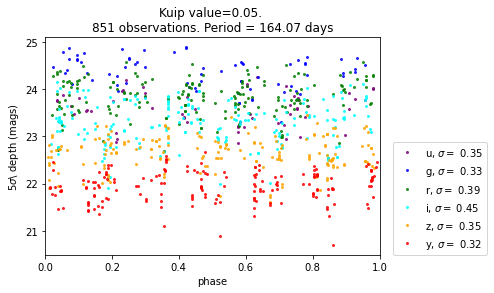

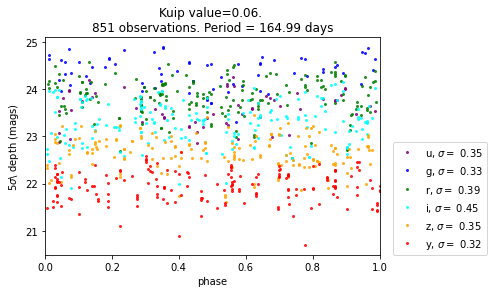

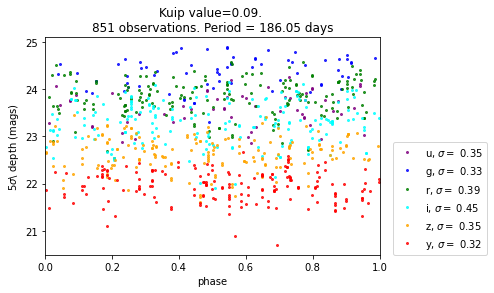

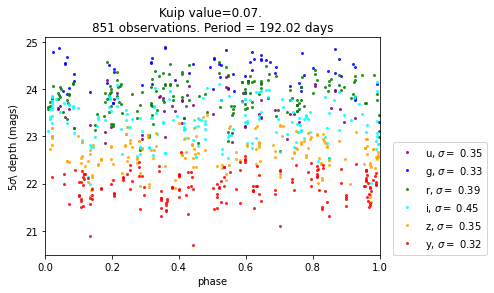

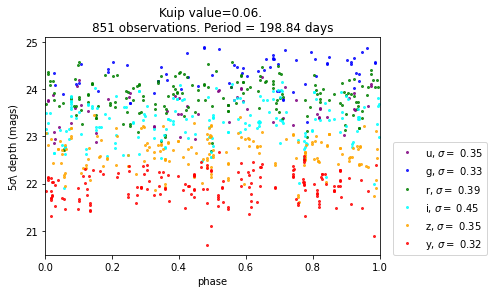

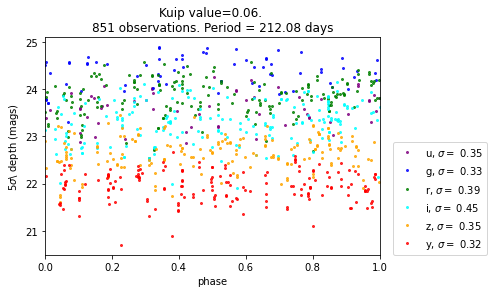

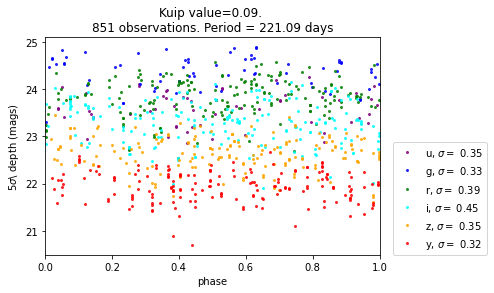

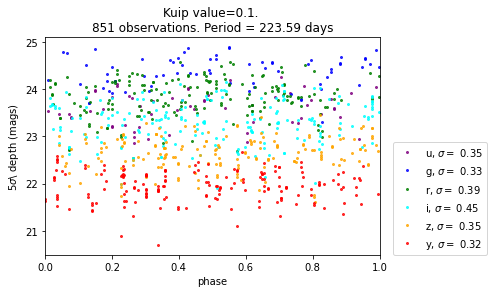

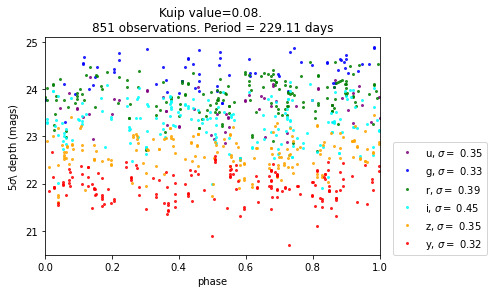

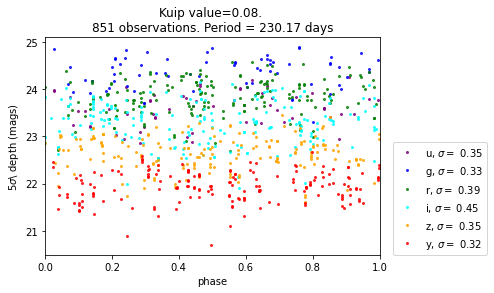

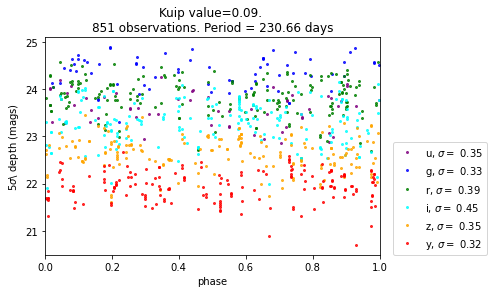

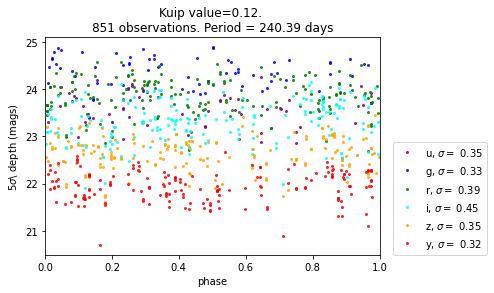

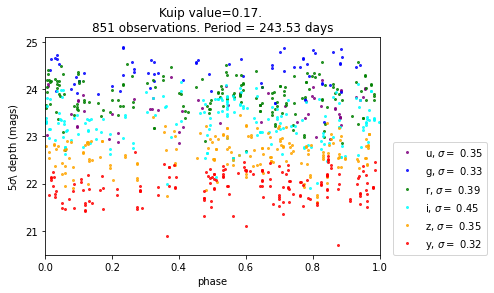

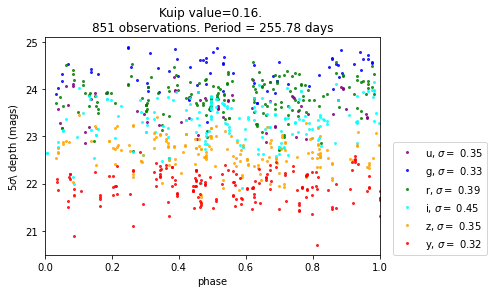

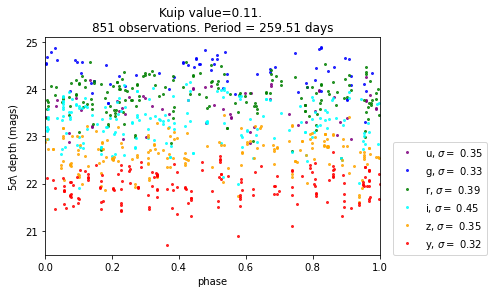

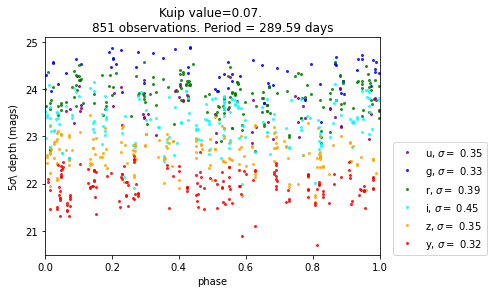

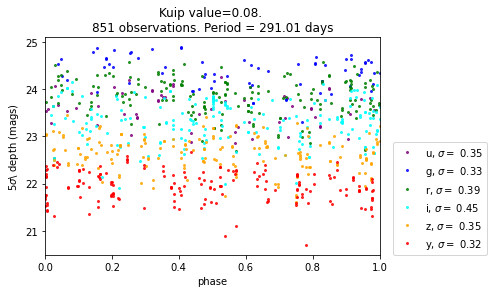

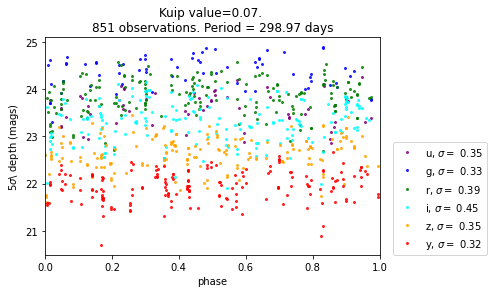

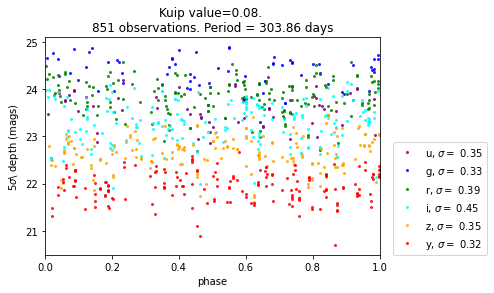

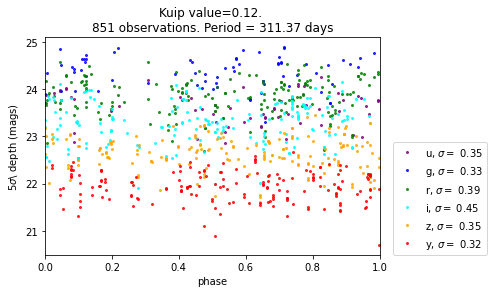

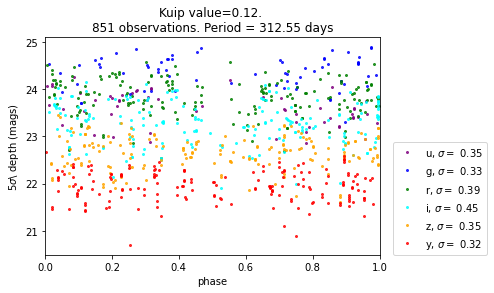

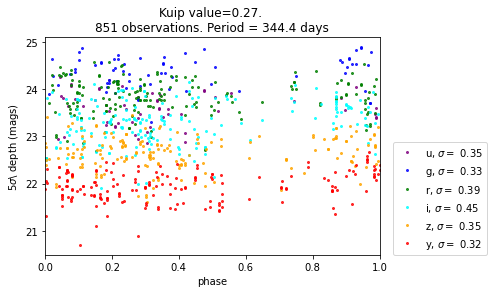

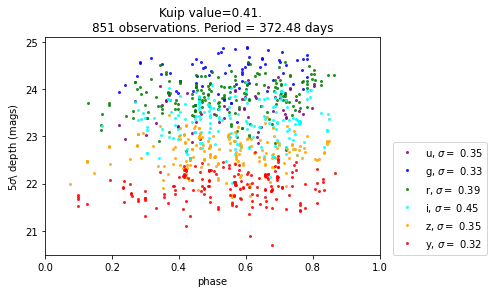

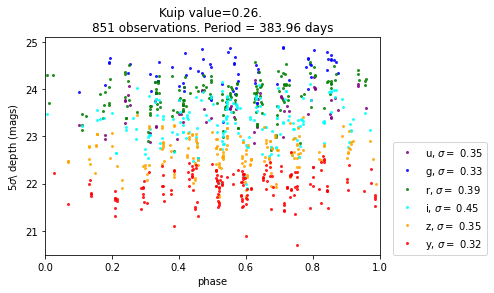

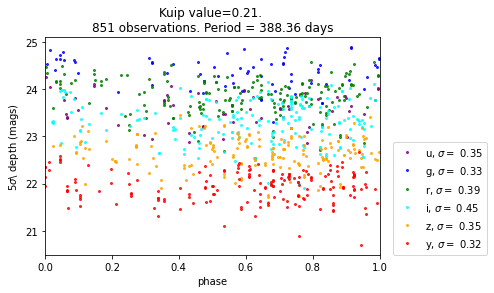

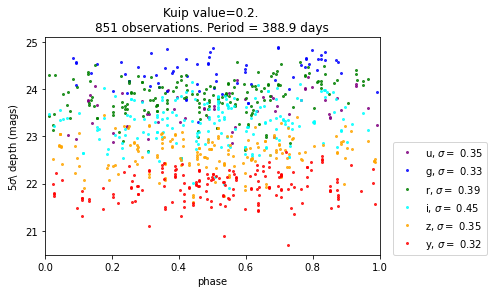

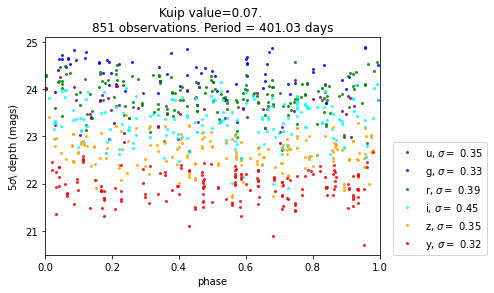

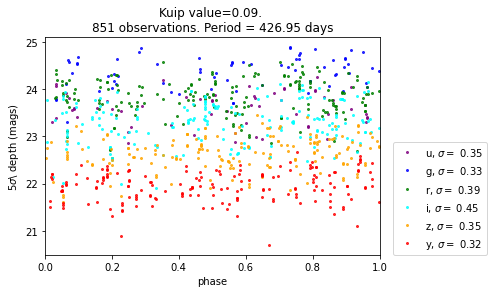

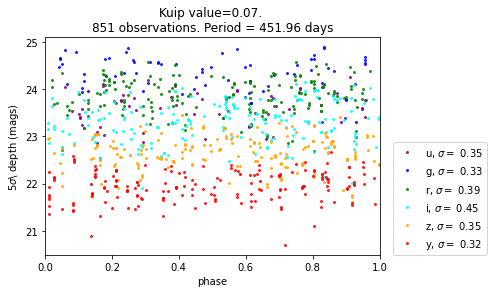

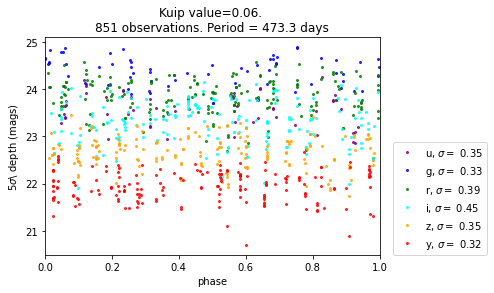

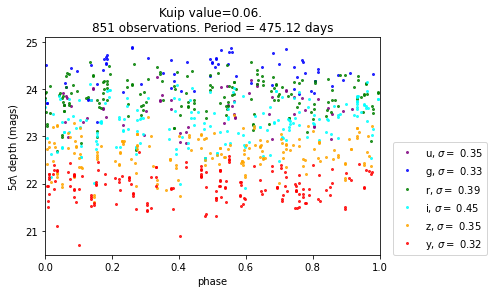

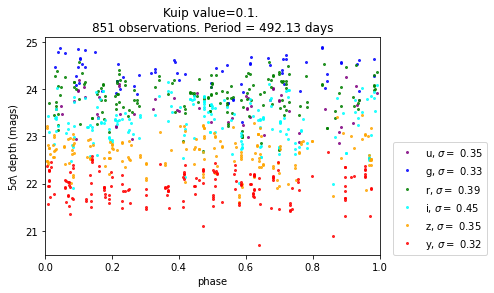

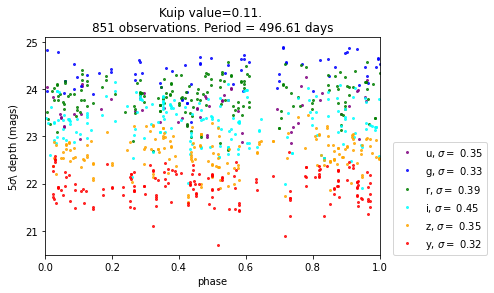

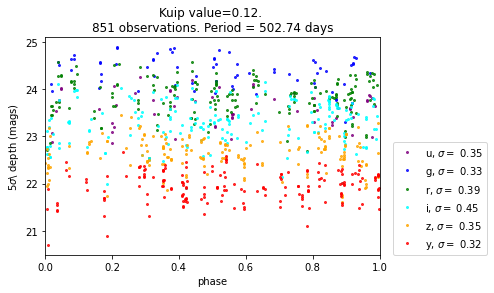

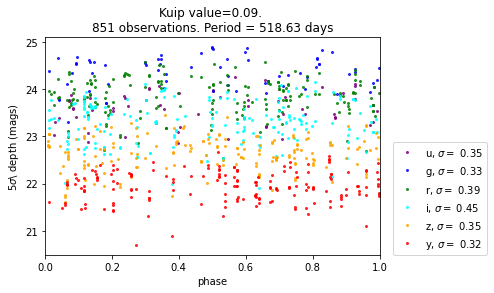

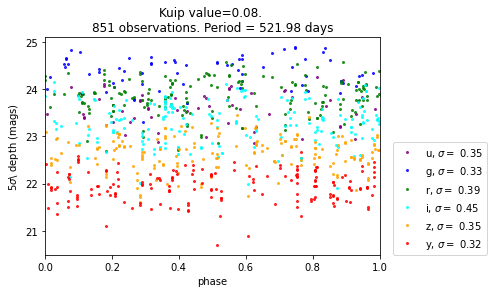

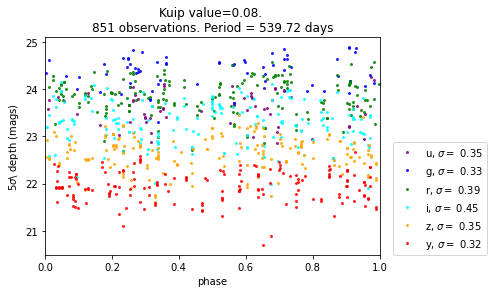

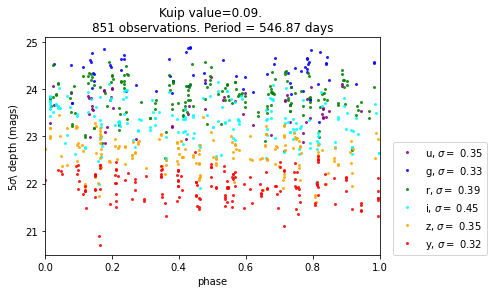

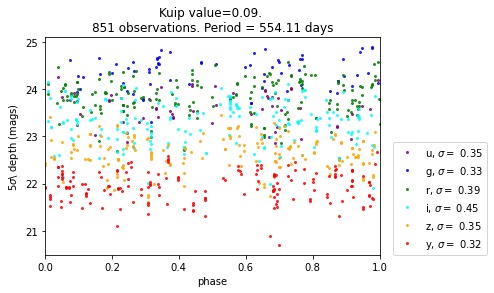

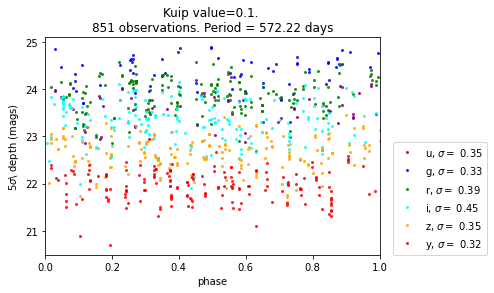

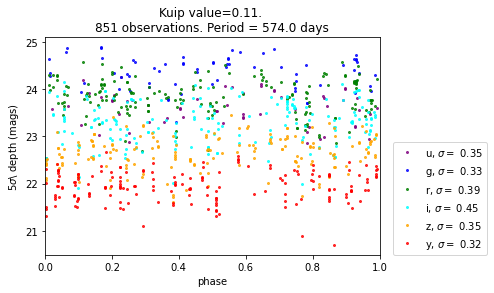

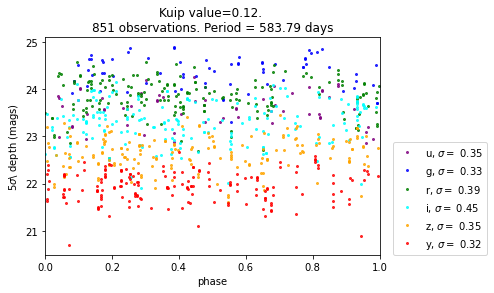

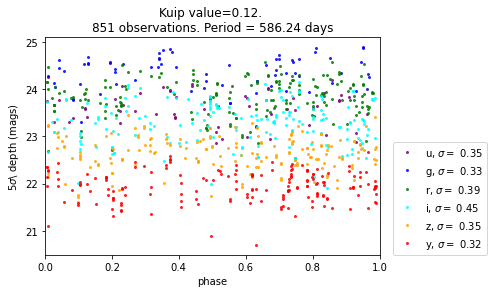

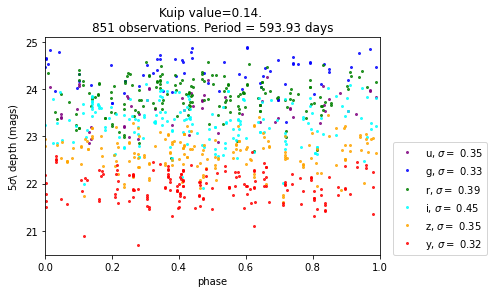

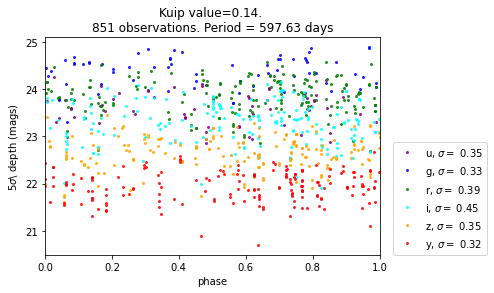

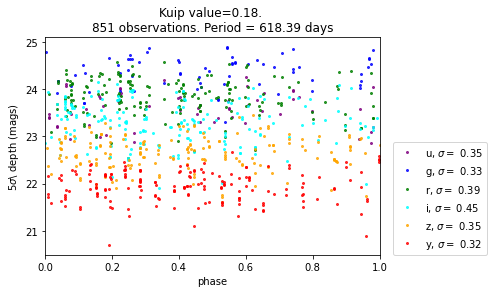

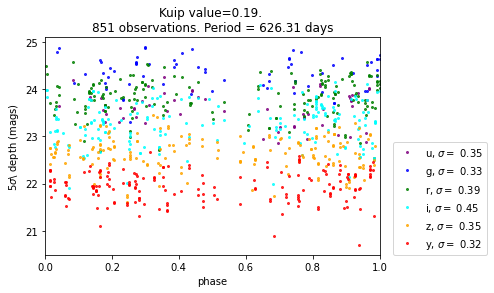

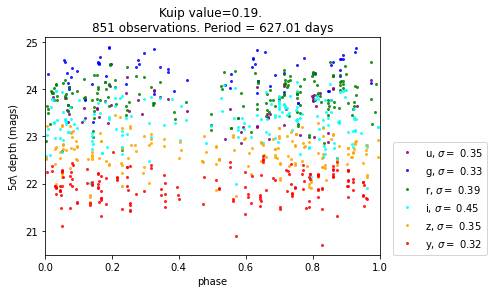

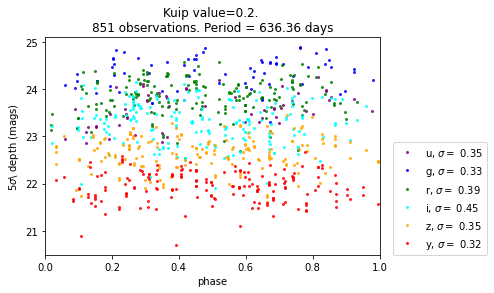

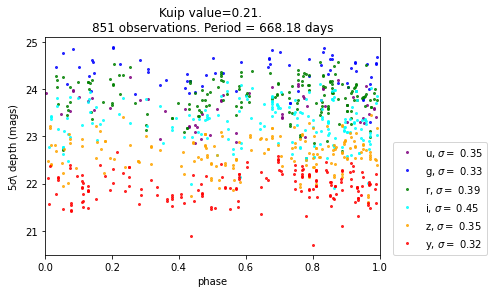

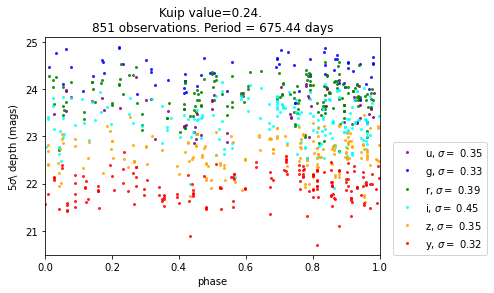

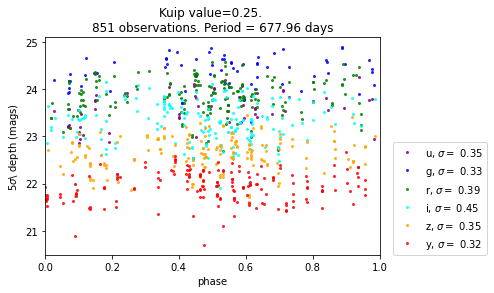

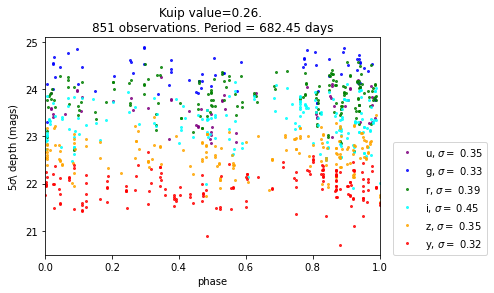

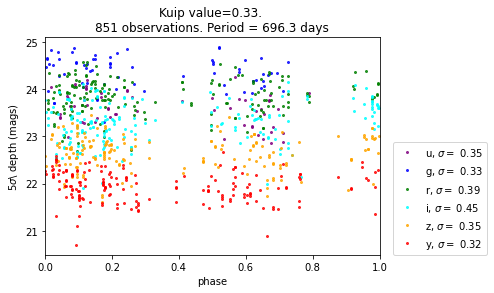

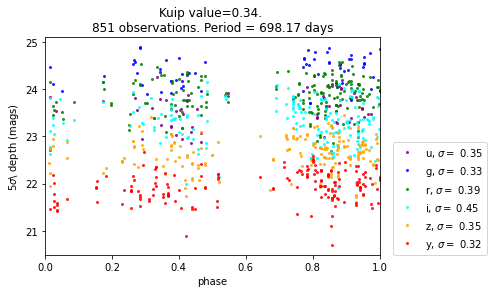

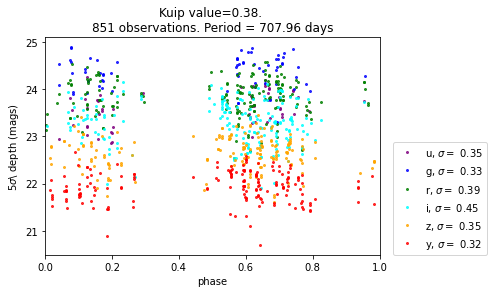

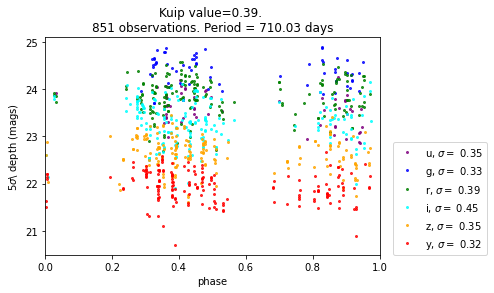

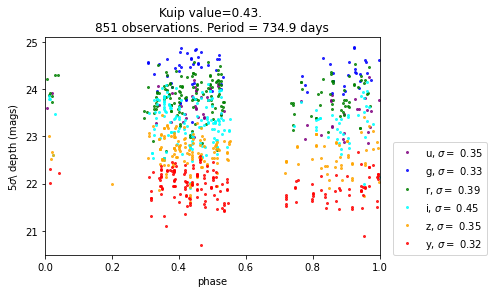

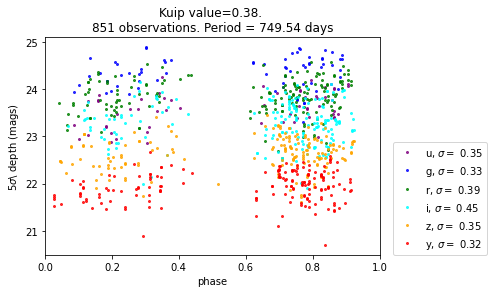

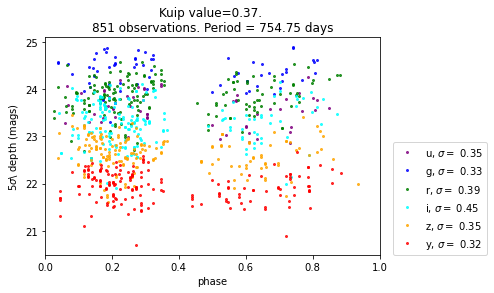

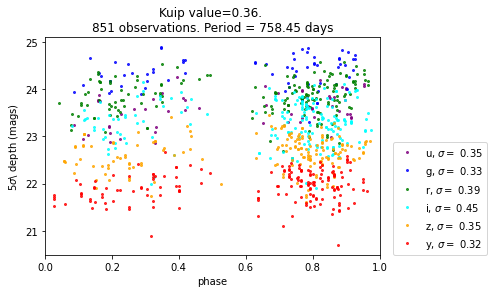

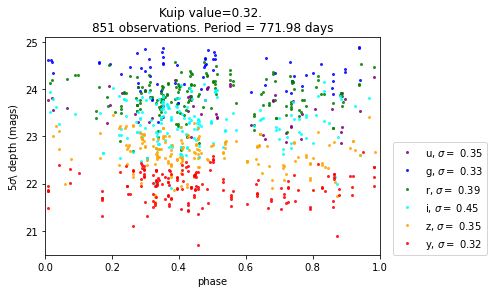

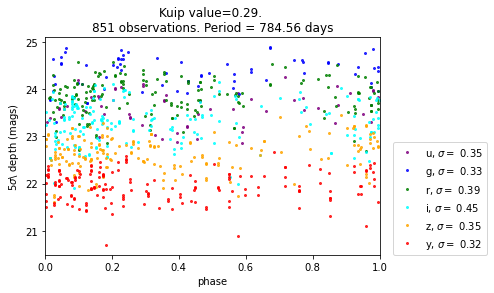

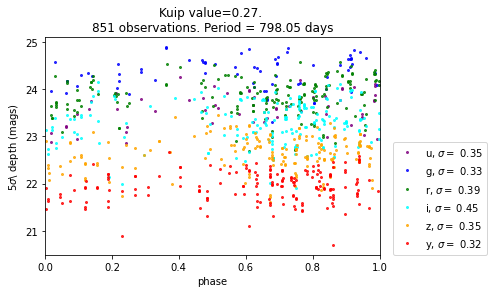

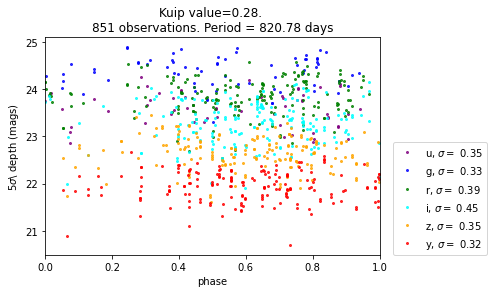

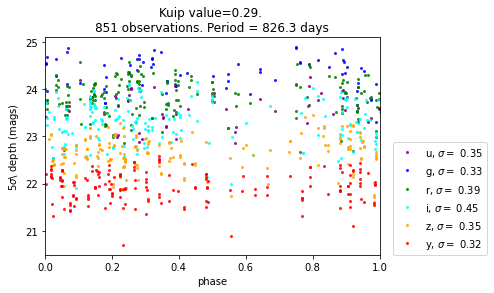

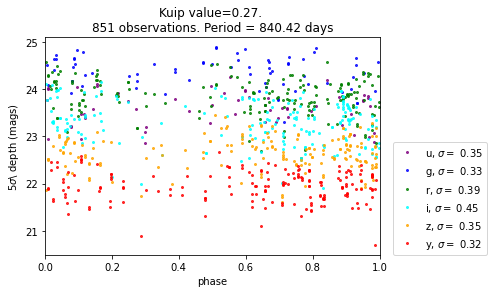

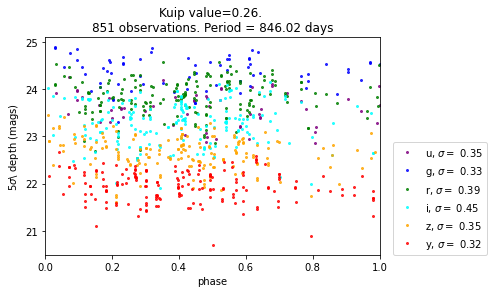

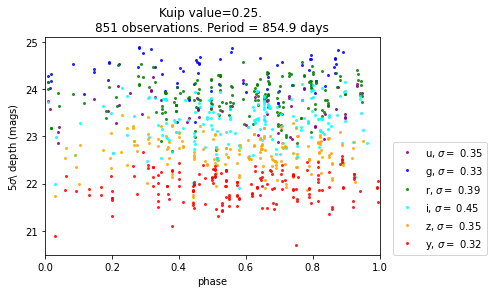

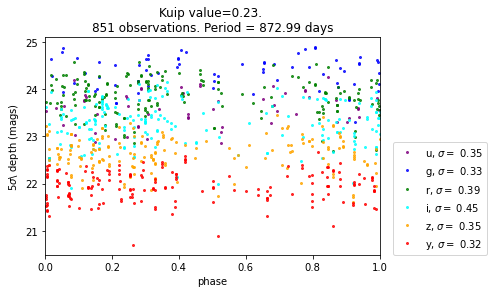

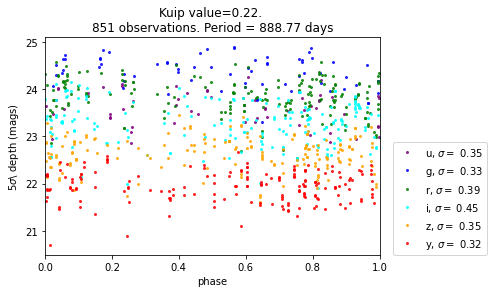

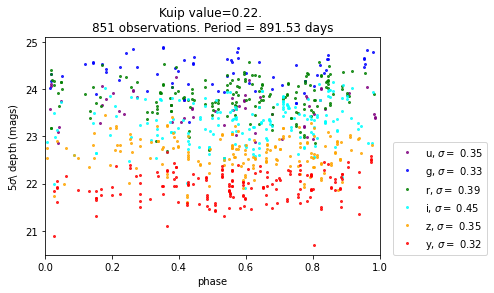

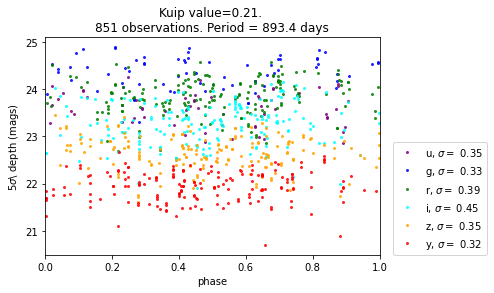

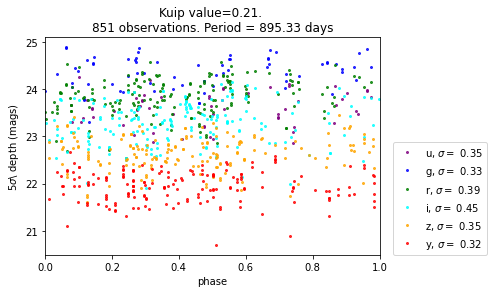

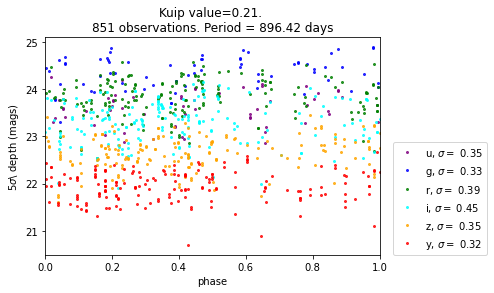

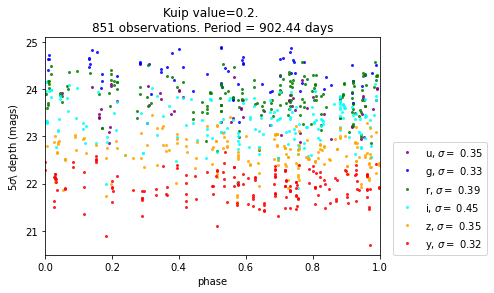

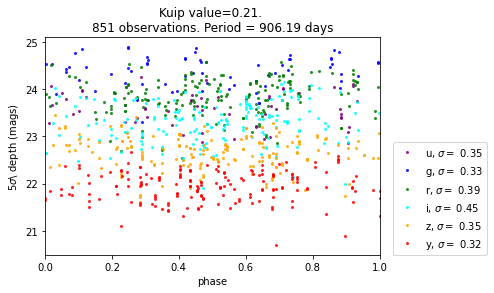

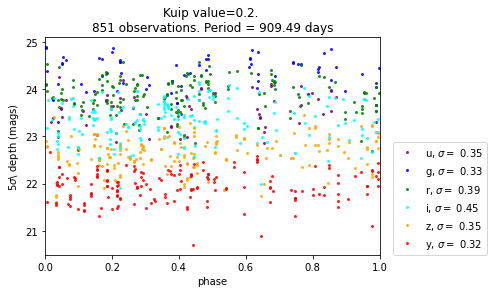

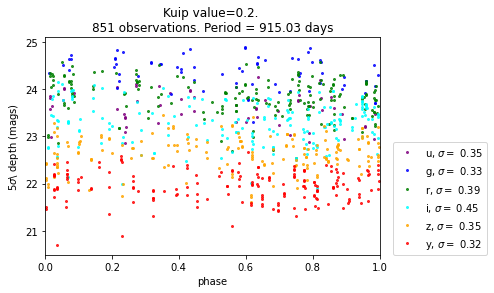

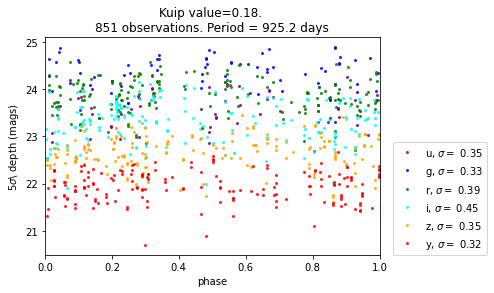

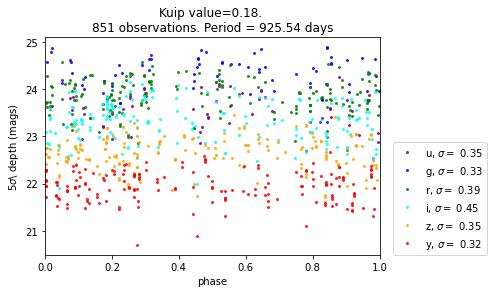

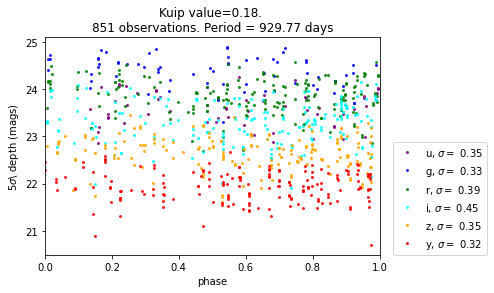

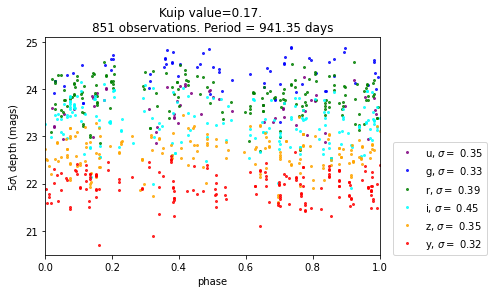

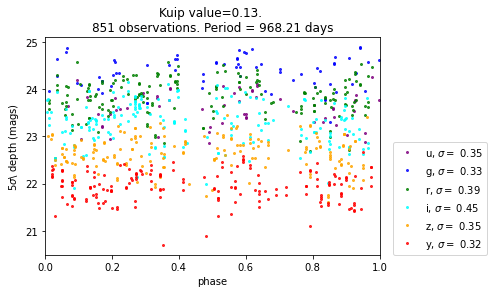

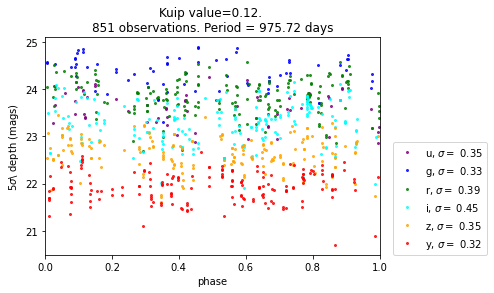

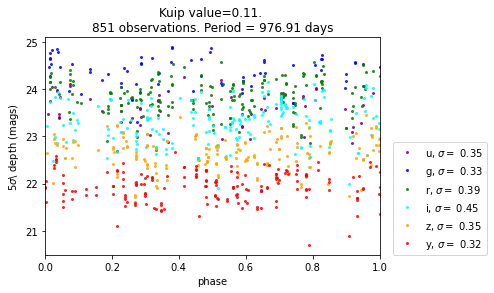

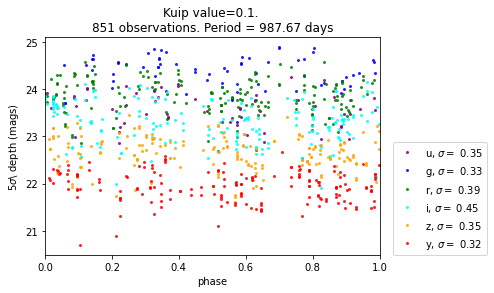

In [58]:
# Plot phased observations 
dataSlice=bundleListPass[0].metricValues.data[~bundleListPass[0].metricValues.mask][0]
new_dt = np.dtype(dataSlice.dtype.descr + [('phasedObs', '<f8')])
dataSlice2 = np.zeros(dataSlice.shape, dtype=new_dt)
for c in dataSlice.dtype.names:
    dataSlice2[c]=dataSlice[c]
    

    
for period,kuipVal in periods.items():
    dataSlice2['phasedObs']=phasedCadence(period=period,dataSlice=dataSlice)

    # Let's plot up what the 5-sigma depth looks like
    plt.figure()
    # Give each filter it's own color
    f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
           'i': 'cyan', 'z': 'orange', 'y': 'red'}
    for fn in f2c:
        in_filt = np.where(dataSlice2['filter'] == fn)[0]
        plt.plot(dataSlice2['phasedObs'][in_filt],
                 dataSlice2['fiveSigmaDepth'][in_filt], 'o',
                 color=f2c[fn],
                 label=fn+r', $\sigma=$ %.2f' % (np.std(dataSlice2['fiveSigmaDepth'][in_filt])),
                 alpha=0.8,
                 markersize=2)
    plt.xlabel('phase')
    plt.ylabel(r'5$\sigma$\ depth (mags)')
    plt.xlim(0,1)
    plt.legend(loc=(1.04,0))
    plt.title('Kuip value='+str(round(kuipVal,2))+'. \n'+
              str(len(dataSlice))+' observations. Period = '+str(period)+' days')